---
# **Exponential Smoothing Model Applied to Bitcoin**

---


### Imports

Installing the dependencies that enables to get access to the dataset

In [1]:
#pip install --upgrade pandas pip install --upgrade pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [2]:
#pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [68]:
import pandas_datareader as pdr
import pandas as pd
from datetime import datetime

In [69]:
import pandas as pd

---
Importing the ExponentialSmoothing algorithm from statsmodels package

In [70]:
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing

---
Through the pandas_datareader, let's get access to the Yahoo Finance.
This line of code will get the data from 2020 afterwards.

In [71]:
df = pdr.get_data_yahoo('BTC-USD')

### Preparing the Data

---
Now, it is time to drop a few columns of the dataset and keep the Close column, in order to proceeding with our implementation

In [72]:
df.drop(['High', 'Low', 'Open', 'Volume', 'Adj Close'], axis=1, inplace=True)

---
Transforming the index in a Date column

In [73]:
df=df.reset_index()

In [74]:
df["Date"] = pd.to_datetime(df["Date"])
df.tail()

,Date,Close
1821,2022-05-07,35501.953125
1822,2022-05-08,34059.265625
1823,2022-05-09,30296.953125
1824,2022-05-10,31022.906250
1825,2022-05-11,31464.388672


---

### Prediction


The following code will train, and fit the model, proceeding with and forecast of the desired amount of days - HORIZON, on this case -.

---

In [75]:
HORIZON = 10

model = ExponentialSmoothing(endog = df['Close'])
results = model.fit()

preds = results.get_forecast(steps=HORIZON)

preds.summary_frame(alpha=0.2).head()

Close,mean,mean_se,mean_ci_lower,mean_ci_upper
1826,31452.337484,988.136173,30185.990025,32718.684943
1827,31452.337484,1379.171200,29684.858474,33219.816495
1828,31452.337484,1681.610330,29297.267133,33607.407835
1829,31452.337484,1937.398618,28969.461252,33935.213716
1830,31452.337484,2163.148980,28680.150523,34224.524445


---
The summary_frame above displays the mean, which on this case is the value predicted, and the confidence interval which is the lower and the upper columns on the very right hand side of the frame.

Note that the Exponential Smoothing prediction of the following 10 steps of the dataset have the same value. What will influency our prediction graph into a straith line.
It is due to the fact that the Exponential Smoothing formula requires the previous value of the dataset to predict the next value, and as our dataset has an ending, the formula will predict only one step ahead.

It does not mean that our prediction is wrong, just shows us that the Simple Exponential Smoothing Statistical prediction has also some sort of limitations. On the other hand, the precition has an upper and a lower bounder, which statistically places our prediction in a range of possible values.

The alternative for this, in case the business case requires more than one step ahead prediction, is to use the Multi-Step Forecasting methods. Not included in this project as our business case does not require it.


---

In [76]:
print(results.forecast(steps=1))

1826    31452.337484
dtype: float64


The print above was done to explore the structure of the returned data from the forecast() function. This line of code is relevant and massively important for our Decision-making feature.

---

### Visualization

---

The plot below displays the predicted values + the confidence interval generated in this model implementation.
For the sake of a better visualization, it was scaled for the last 25 observations.

---

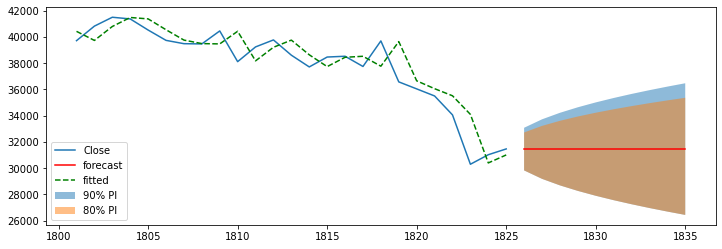

In [77]:
ax = df['Close'].iloc[-25:].plot(figsize=(12,4))
forecast_80 = preds.summary_frame(alpha=0.2)[['mean', 'mean_ci_lower', 'mean_ci_upper']]
forecast_90 = preds.summary_frame(alpha=0.1)[['mean', 'mean_ci_lower', 'mean_ci_upper']]

ax.fill_between(forecast_90.index, forecast_90['mean_ci_lower'], forecast_90['mean_ci_upper'], alpha=0.5, label='90% PI')
ax.fill_between(forecast_80.index, forecast_90['mean_ci_lower'], forecast_80['mean_ci_upper'], alpha=0.5, label='80% PI')

forecast_80['mean'].iloc[-25:].plot(ax=ax, label='forecast', color='red')

results.fittedvalues.iloc[-25:].plot(ax=ax, label='fitted', color='green', linestyle='--')

ax.legend(loc=3)

### Evaluation

Statistical model

In [11]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Exponential Smoothing Results                         
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1826
Model:                   ETS(A, N, N)   Log Likelihood              -15182.656
Date:                Wed, 11 May 2022   AIC                          30371.311
Time:                        15:07:54   BIC                          30387.841
Sample:                             0   HQIC                         30377.408
                               - 1826   Scale                       976312.037
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9736      0.015     65.838      0.000       0.945       1.003
initial_level    1724.2400   4.57e+05      0.004      0.997   -8.93e+05    8.97e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8400.63
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              14.08   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from itertools import product
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Model residuals

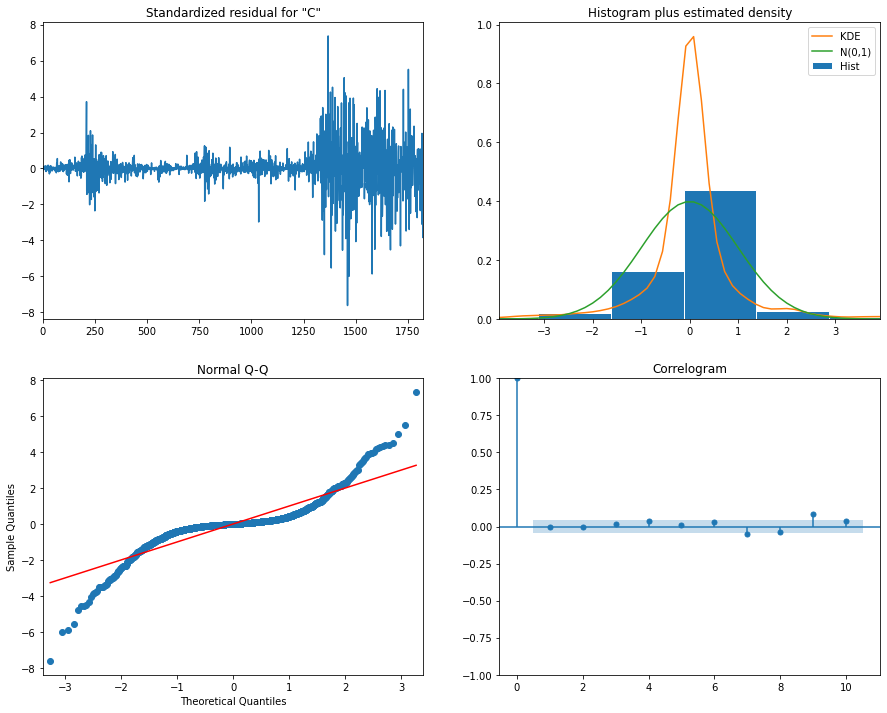

In [13]:
# Diagnosing the model residuals
results.plot_diagnostics(figsize = (15, 12))
plt.show()

In [14]:
# Divide into train and validation set to calculate R-squared score
train = df[:int(0.85 * (len(df)))]
test  = df[int(0.85 * (len(df))):]

train.shape, test.shape

((1552, 2), (274, 2))

In [15]:
start = len(train)
end   = len(train) + len(test) - 1
predictions = results.predict(start = start, end = end, dynamic = False, typ = 'levels').rename('Simple Exponential Smoothing Predictions')
print(predictions)

1552    45603.855616
1553    45593.906479
1554    44459.059187
1555    47705.302042
1556    47113.004795
            ...     
1821    36057.165255
1822    35516.609689
1823    34097.736788
1824    30397.286720
1825    31006.391062
Name: Simple Exponential Smoothing Predictions, Length: 274, dtype: float64


In [16]:
# Create a dataframe to store r2 score
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['Close'], predictions)}, index = [0])

# Display the results
evaluation_results

,r2_score
0,0.960394


**The evaluation of our r2_score and residuals brings us a pretty good accurancy without overfitting.**

---

---

# Exponential Smoothing Model applied to ETHERIUM

To proceed with this implementation we will follow the same steps as the bitcoin implementation

---

In [17]:
df_eth = pdr.get_data_yahoo('ETH-USD')

In [18]:
df_eth.drop(['High', 'Low', 'Open', 'Volume', 'Adj Close'], axis=1, inplace=True)

In [19]:
df_eth=df_eth.reset_index()

In [20]:
df_eth["Date"] = pd.to_datetime(df_eth["Date"])
df.tail()

,Date,Close
1821,2022-05-07,35501.953125
1822,2022-05-08,34059.265625
1823,2022-05-09,30296.953125
1824,2022-05-10,31022.906250
1825,2022-05-11,31165.041016


In [21]:
df_eth.head(10000)

,Date,Close
0,2017-11-09,320.884003
1,2017-11-10,299.252991
2,2017-11-11,314.681000
3,2017-11-12,307.907990
4,2017-11-13,316.716003
...,...,...
1640,2022-05-07,2636.093018
1641,2022-05-08,2517.459961
1642,2022-05-09,2245.430420
1643,2022-05-10,2343.510986


In [22]:
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing

In [23]:
HORIZON = 10

model_eth = ExponentialSmoothing(endog = df_eth['Close'])
results_eth = model_eth.fit()

preds_eth = results_eth.get_forecast(steps=HORIZON)

preds_eth.summary_frame(alpha=0.2).head()

Close,mean,mean_se,mean_ci_lower,mean_ci_upper
1645,2329.904335,79.814048,2227.618517,2432.190153
1646,2329.904335,109.166591,2190.001719,2469.806951
1647,2329.904335,132.152969,2160.543491,2499.265179
1648,2329.904335,151.695318,2135.498963,2524.309707
1649,2329.904335,168.992698,2113.331478,2546.477191


In [24]:
preds_eth.summary_frame(alpha=0.2).head(10)

Close,mean,mean_se,mean_ci_lower,mean_ci_upper
1645,2329.904335,79.814048,2227.618517,2432.190153
1646,2329.904335,109.166591,2190.001719,2469.806951
1647,2329.904335,132.152969,2160.543491,2499.265179
1648,2329.904335,151.695318,2135.498963,2524.309707
1649,2329.904335,168.992698,2113.331478,2546.477191
1650,2329.904335,184.677000,2093.231236,2566.577433
1651,2329.904335,199.129749,2074.709294,2585.099376
1652,2329.904335,212.602256,2057.443581,2602.365089
1653,2329.904335,225.270463,2041.208620,2618.600050
1654,2329.904335,237.263238,2025.839261,2633.969409


---

The plot below displays the predicted values + the confidence interval generated in this model implementation.
For the sake of a better visualization, it was scaled for the last 85 observations.

---

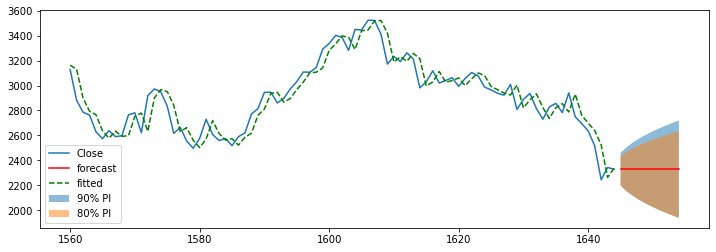

In [25]:
ax_eth = df_eth['Close'].iloc[-85:].plot(figsize=(12,4))
forecast_80_eth = preds_eth.summary_frame(alpha=0.2)[['mean', 'mean_ci_lower', 'mean_ci_upper']]
forecast_90_eth = preds_eth.summary_frame(alpha=0.1)[['mean', 'mean_ci_lower', 'mean_ci_upper']]

ax_eth.fill_between(forecast_90_eth.index, forecast_90_eth['mean_ci_lower'], forecast_90_eth['mean_ci_upper'], alpha=0.5, label='90% PI')
ax_eth.fill_between(forecast_80_eth.index, forecast_90_eth['mean_ci_lower'], forecast_80_eth['mean_ci_upper'], alpha=0.5, label='80% PI')

forecast_80_eth['mean'].iloc[-85:].plot(ax=ax_eth, label='forecast', color='red')

results_eth.fittedvalues.iloc[-85:].plot(ax=ax_eth, label='fitted', color='green', linestyle='--')

ax_eth.legend(loc=3)

In [27]:
results_eth.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Exponential Smoothing Results                         
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1645
Model:                   ETS(A, N, N)   Log Likelihood               -9538.760
Date:                Wed, 11 May 2022   AIC                          19083.519
Time:                        15:19:48   BIC                          19099.736
Sample:                             0   HQIC                         19089.533
                               - 1645   Scale                         6370.282
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9332      0.013     72.910      0.000       0.908       0.958
initial_level     320.8837   4374.901      0.073      0.942   -8253.764    8895.531
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             23706.14
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              17.25   Skew:                            -0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from itertools import product
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Model residuals

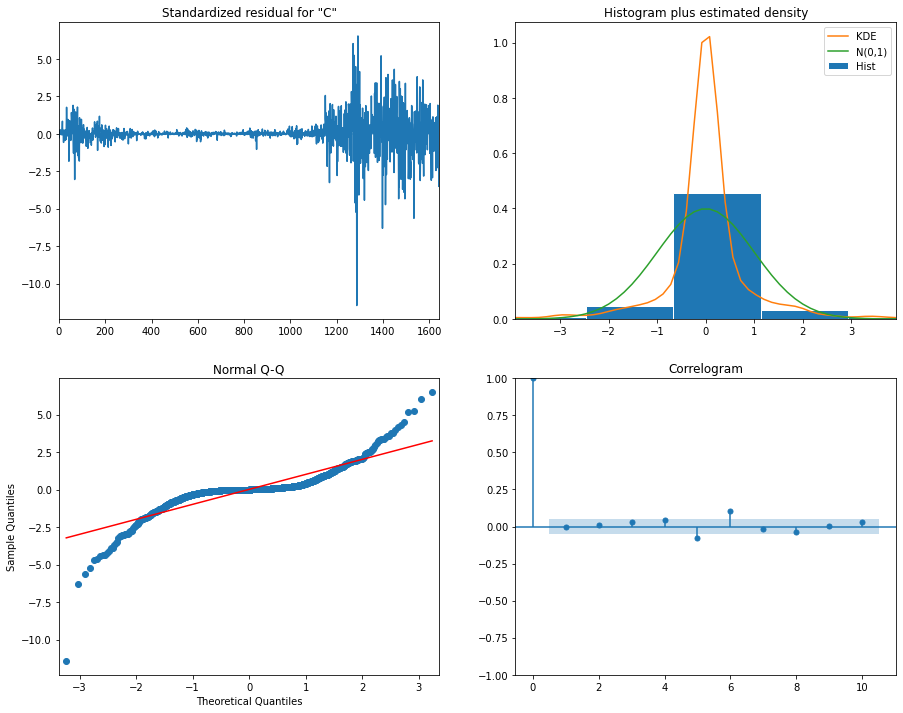

In [29]:
# Diagnosing the model residuals
results_eth.plot_diagnostics(figsize = (15, 12))
plt.show()

In [30]:
# Divide into train and validation set to calculate R-squared score
train_eth = df_eth[:int(0.85 * (len(df_eth)))]
test_eth  = df_eth[int(0.85 * (len(df_eth))):]

train_eth.shape, test_eth.shape

((1398, 2), (247, 2))

In [31]:
start_eth = len(train_eth)
end_eth   = len(train_eth) + len(test_eth) - 1
predictions_eth = results_eth.predict(start = start_eth, end = end_eth, dynamic = False, typ = 'levels').rename('Simple Exponential Smoothing Predictions')
print(predictions_eth)

1398    3929.692763
1399    3460.039003
1400    3494.823331
1401    3431.851237
1402    3226.235603
           ...     
1640    2699.415086
1641    2640.325999
1642    2525.673363
1643    2264.164222
1644    2338.206779
Name: Simple Exponential Smoothing Predictions, Length: 247, dtype: float64


In [32]:
# Create a dataframe to store r2 score
evaluation_results_eth = pd.DataFrame({'r2_score': r2_score(test_eth['Close'], predictions_eth)}, index = [0])

# Display the results
evaluation_results_eth

,r2_score
0,0.953503


**Although, the implementation of our Statistical Exponential Smoothing Model on Etherium is slightly lower than with the Bitcoin, it is still presenting good results.**

---

---

# Automation and Decision-Making Function: Custom Made Function to train the model, request external API and come up with an "advice"

---

The function below will perform the following tasks:
*  Train the model once a day
*  Find the middle value of the dataset
*  HTTP request to find the real time of the crypto (Bitcoin)
*  According to the position of value-predicted for the following day/real-time value in comparison with the top and bottom section defined in the business case, return an statistical advice.

---


In [78]:
import requests

In [79]:
from threading import Timer

The packages above have the purpose of:
* requests = prooceding with the API call to find out the real value of the Bitcoin
* Timer from threading = create a time-interval which will recursively call the custom made functions

---

The API chosen to check the real time value of the Bitcoin was bitpay.com.
The function below returns only the required rate

In [80]:
def find_real_time_value():
    real_time_price = requests.get('https://bitpay.com/api/rates/USD')
    x = real_time_price.json()
    return x['rate']


---
The following custom made function receives as a parameter a dataset, and returns the middle value of the dataset.
This step will help in the Decision-making feature.

---

In [81]:
def get_middle_value(data):
    high = 0
    low = 0
    middle_value = 0
    
    # Finding higher and lowest values in order to get a middle value
    for x in data:
        if high > x:
            high = high
        else:
            high = x
        
        if low < x:
            low = low
        else:
            low = x
        
        middle_value = (high - low)/2 
            
    return middle_value

test = get_middle_value(df['Close'])
print(test)

33783.4140625


---
The following two custom made functions, are as follows:
* **get_highest**: Receives a dataset, returns the highest value of it
* **get_lowest**: Receives a dataset, returns the lowest value presented on it

---

In [82]:
def get_highest(data):
    highest = 0
    for x in data:
        if highest > x:
            highest = highest
        else:
            highest = x
            
    return highest

In [83]:
def get_lowest(data):
    lowest = 0
    for x in data:
        if lowest < x:
            lowest = lowest
        else:
            lowest = x
            
    return lowest

---
The **model_training** function receives **two parameters**:
* dataset
* days to predict

Although the function will proceed with the model fitting and prediction, it is still need the datapreparation to be done before the dataset be sent as parameter.

The first 'setInterval' is used, making the model_training function runs every 24 hours.

---

In [84]:
def read_dataset():
    df = pdr.get_data_yahoo('BTC-USD')
    df.drop(['High', 'Low', 'Open', 'Volume', 'Adj Close'], axis=1, inplace=True)
    df=df.reset_index()
    df["Date"] = pd.to_datetime(df["Date"])
    return df

In [86]:
test = read_dataset()
print(test['Close'])

0        1724.239990
1        1804.910034
2        1808.910034
3        1738.430054
4        1734.449951
            ...     
1821    35501.953125
1822    34059.265625
1823    30296.953125
1824    31022.906250
1825    31641.576172
Name: Close, Length: 1826, dtype: float64


In [99]:
# Train the Model
# Function to train a general model every 24h

def model_training(days_to_predict):
    run = True
    HORIZON = days_to_predict
    
    data = read_dataset()

    model = ExponentialSmoothing(endog = data['Close'])
    results = model.fit()
    
    def call_train():
        model_training(dataset, days_to_predict)
        
    if run:
        Timer(86400, call_train).start()
    
    return results

---
The cherry on the top of the cake:

**statistical_decision() function.**

The function receives the following parameters:
* The fitted Model
* The dataset

The function works as follows:

*First Phase*

1. The function calls the get_highest and the get_lowest functions
2. Sets a top_bounder and bottom_bounder with a zero initial value
3. Sets run = True (run will enables the Timer runs and the automation works)

*Second Phase*

1. Gets the real time of the Bitcoin, calling the find_real_time_value()
2. Gets the middle value, calling the get_middle_value function
3. Re-assign the top_bounder and the bottom_bounder to 2/3 of the highest and the lowest values, respectively.

*Third Phase*

- The Decision-making logic

The decision-making logic is based on the business case of the project.
The variable 'v' receives the step ahead predicted value, and confronts it with the top and bottom bounders previously defined, returning a statistical decision according to where the predicted value is in relation to the defined top and bottom bounders.

The timer runs every minute as the API updates the bitcoin real time value each 60s.


---

In [100]:
def statistical_decision(model, data):
    # Defining boundaries
    high = get_highest(data)
    low = get_lowest(data)
    
    top_bounder = 0
    bottom_bounder = 0
    
    run = True
    
    # Checking real time of the bitcoin in USD
    x = find_real_time_value()
    
    # Get Middle value
    m = get_middle_value(data)
    one_third_high = (high - m)/3
    one_third_bottom = (low - m)/3
    top_bounder = m + one_third_high * 2
    bottom_bounder = m + one_third_bottom * 2 
    
    # Decision logic
    model2 = model_training(10)
    v = model2.forecast(steps=1)
    
    to_return_1 = 'Real time value is:'
    to_return_2 = 'Predicted value for tomorrow is:'
    
    if v.item() > top_bounder:
        print('Sell!', to_return_1, x, to_return_2, v.item())
    
    elif v.item() < bottom_bounder:
        print('Sell!', to_return_1, x, to_return_2, v.item())
    
    elif v.item() > bottom_bounder:
        print('Buy!', to_return_1, x, to_return_2, v.item())
    
    elif v.item() < top_bounder:
        print('Buy!', to_return_1, x, to_return_2, v.item())
        
    def call():
        statistical_decision(model, data)
        
    if run:
        Timer(60, call).start()
        
    

---

Calling the statistical_decision() function and passing as parameter:
- The model = results
- The dataset = df['Close']

In [101]:
statistical_decision(results, df['Close'])

Buy! Real time value is: 31426.39 Predicted value for tomorrow is: 31484.410912267722
Buy! Real time value is: 31500.72 Predicted value for tomorrow is: 31484.410912267722
Buy! Real time value is: 31562.96 Predicted value for tomorrow is: 31466.092674323307
Buy! Real time value is: 31564.83 Predicted value for tomorrow is: 31469.392643904266
Buy! Real time value is: 31692.51 Predicted value for tomorrow is: 31519.695614391203
